# Market Product Distribution Route Optimization

## Project Overview
This notebook solves  Travelling Salesman Problem (TSP) for optimal product distribution across multiple counties in Kenya. The solution:
- Starts and ends in Nairobi
- Visits Meru, Nyeri, Nandi, Kericho, and Nakuru exactly once
- Minimizes total travel distance
- Uses real geographical data
- Provides visualizations
- Measures performance

## Table of Contents
1. [Setup and Dependencies](#Setup-and-Dependencies)
2. [Location Data Collection](#Location-Data-Collection)
3. [Distance Matrix Calculation](#Distance-Matrix-Calculation)
4. [TSP Algorithm Implementation](#TSP-Algorithm-Implementation)
5. [Solution Visualization](#Solution-Visualization)
6. [Performance Analysis](#Performance-Analysis)
7. [Generalized Solution](#Generalized-Solution)

In [4]:
# Setup and Dependencies
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import folium
import time
import geopy.distance
from geopy.geocoders import Nominatim
from itertools import permutations
from IPython.display import display, Markdown
import sys
import warnings

# Configuration
warnings.filterwarnings('ignore')  # Cleaner output
pd.set_option('display.max_columns', None)  # Show all DataFrame columns
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping

# Configure matplotlib for Jupyter
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution plots

# Set optimal style
current_style = 'seaborn-v0_8'
plt.style.use(current_style)
mpl.rcParams['figure.figsize'] = (10, 6)  # Default figure size
mpl.rcParams['font.size'] = 12  # Base font size

# Display environment information
display(Markdown("### Environment Configuration"))
env_info = pd.DataFrame({
    'Package': ['Python', 'NumPy', 'Pandas', 'Matplotlib', 'Folium', 'Geopy'],
    'Version': [
        sys.version.split()[0],
        np.__version__,
        pd.__version__,
        mpl.__version__,
        folium.__version__,
        geopy.__version__
    ]
})
display(env_info)

# Display style information
display(Markdown("### Visualization Settings"))
style_info = pd.DataFrame({
    'Setting': ['Current Style', 'Figure Size', 'Font Size'],
    'Value': [
        current_style,
        f"{mpl.rcParams['figure.figsize']} inches",
        f"{mpl.rcParams['font.size']} pt"
    ]
})
display(style_info)

# Additional configuration for geopy to avoid timeout errors
geolocator = Nominatim(user_agent="tsp_optimizer_v1", timeout=10)
print("\nSystem configured successfully with optimal settings.")

### Environment Configuration

,Package,Version
0,Python,3.10.12
1,NumPy,1.24.3
2,Pandas,2.2.0
3,Matplotlib,3.8.3
4,Folium,0.19.6
5,Geopy,2.4.1


### Visualization Settings

,Setting,Value
0,Current Style,seaborn-v0_8
1,Figure Size,"[10.0, 6.0] inches"
2,Font Size,12.0 pt



System configured successfully with optimal settings.


## Setup and Dependencies
We import all necessary libraries:
- `numpy` for numerical operations
- `pandas` for data structures
- `matplotlib` for basic visualizations
- `folium` for interactive maps
- `geopy` for geocoding and distance calculations
- `time` for performance measurement
- `itertools` for brute-force permutation generation

The `%matplotlib inline` magic command ensures plots appear in the notebook.

In [5]:
# Location Data Collection
def get_coordinates(location_name):
    """Fetch latitude and longitude for a given location name using Nominatim API."""
    geolocator = Nominatim(user_agent="tsp_optimizer")
    location = geolocator.geocode(location_name + ", Kenya")
    if location:
        return (location.latitude, location.longitude)
    return None

# List of locations in our distribution route
locations = [
    "Nairobi",
    "Meru",
    "Nyeri",
    "Nandi",
    "Kericho",
    "Nakuru"
]

# Fetch coordinates for each location
location_coords = {}
for loc in locations:
    coords = get_coordinates(loc)
    if coords:
        location_coords[loc] = coords
        print(f"Found coordinates for {loc}: {coords}")
    else:
        print(f"Could not find coordinates for {loc}")

# Convert to DataFrame for better visualization
coords_df = pd.DataFrame.from_dict(location_coords, orient='index', columns=['Latitude', 'Longitude'])
display(coords_df)

Found coordinates for Nairobi: (-1.2832533, 36.8172449)
Found coordinates for Meru: (0.2254509, 37.7772624)
Found coordinates for Nyeri: (-0.4192962, 36.9517005)
Found coordinates for Nandi: (0.2253932, 35.1244929)
Found coordinates for Kericho: (-0.3209968, 35.2261276)
Found coordinates for Nakuru: (-0.2802724, 36.0712048)


,Latitude,Longitude
Nairobi,-1.283253,36.817245
Meru,0.225451,37.777262
Nyeri,-0.419296,36.951701
Nandi,0.225393,35.124493
Kericho,-0.320997,35.226128
Nakuru,-0.280272,36.071205


## Location Data Collection
This section:
1. Defines a `get_coordinates()` function that uses the Nominatim geocoding service to convert location names to (latitude, longitude) tuples
2. Creates a list of our target locations
3. Fetches and stores coordinates for each location
4. Displays the results in a clean DataFrame

The Nominatim API is free but has usage limits. For production use, consider:
- Adding error handling
- Implementing rate limiting
- Using a commercial geocoding service

In [7]:
# Distance Matrix Calculation
def calculate_distance_matrix(coords_dict):
    """Calculate road distances between all pairs of locations using geodesic distance."""
    locations = list(coords_dict.keys())
    n = len(locations)
    distance_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                distance_matrix[i][j] = 0
            else:
                coord1 = coords_dict[locations[i]]
                coord2 = coords_dict[locations[j]]
                distance_matrix[i][j] = geopy.distance.geodesic(coord1, coord2).km
    
    return pd.DataFrame(distance_matrix, index=locations, columns=locations)

# Calculate and display distance matrix
start_time = time.time()
distance_df = calculate_distance_matrix(location_coords)
calculation_time = time.time() - start_time

display(Markdown(f"### Distance Matrix (km) - Calculated in {calculation_time:.4f} seconds"))
display(distance_df)

### Distance Matrix (km) - Calculated in 0.0131 seconds

,Nairobi,Meru,Nyeri,Nandi,Kericho,Nakuru
Nairobi,0.000000,198.115050,96.696803,251.657203,206.607542,138.547385
Meru,198.115050,0.000000,116.311303,295.302679,290.346667,197.978402
Nyeri,96.696803,116.311303,0.000000,215.532519,192.393174,99.212669
Nandi,251.657203,295.302679,215.532519,0.000000,61.466897,119.301216
Kericho,206.607542,290.346667,192.393174,61.466897,0.000000,94.179991
Nakuru,138.547385,197.978402,99.212669,119.301216,94.179991,0.000000


## Distance Matrix Calculation
This section:
1. Defines `calculate_distance_matrix()` which computes the geodesic (great-circle) distance between all location pairs
2. Creates a symmetric matrix where each entry (i,j) represents the distance between location i and j
3. Measures and displays the computation time
4. Presents the results in a DataFrame

Note: Geodesic distance is "as the crow flies" and may not match road distance exactly. For more accuracy:
- Use a routing API like OSRM or Google Maps
- Cache results to avoid repeated API calls

In [8]:
# TSP Algorithm Implementation
def tsp_brute_force(distance_matrix):
    """Solve TSP using brute-force permutation approach (only feasible for small n)."""
    n = len(distance_matrix)
    locations = list(distance_matrix.index)
    
    # Generate all possible permutations
    all_routes = permutations(range(1, n))
    
    # Find the shortest route
    min_distance = float('inf')
    optimal_route = None
    
    for route in all_routes:
        current_distance = 0
        current_route = [0] + list(route) + [0]  # Start and end at 0 (Nairobi)
        
        # Calculate total distance for this route
        for i in range(len(current_route)-1):
            current_distance += distance_matrix.iloc[current_route[i], current_route[i+1]]
        
        if current_distance < min_distance:
            min_distance = current_distance
            optimal_route = current_route
    
    # Convert indices to location names
    optimal_route_names = [locations[i] for i in optimal_route]
    return optimal_route_names, min_distance

# Solve TSP
start_time = time.time()
optimal_route, min_distance = tsp_brute_force(distance_df)
execution_time = time.time() - start_time

display(Markdown(f"### TSP Solution - Calculated in {execution_time:.4f} seconds"))
display(Markdown(f"**Optimal Route:** {' → '.join(optimal_route)}"))
display(Markdown(f"**Total Distance:** {min_distance:.2f} km"))

### TSP Solution - Calculated in 0.0365 seconds

**Optimal Route:** Nairobi → Kericho → Nandi → Nakuru → Meru → Nyeri → Nairobi

**Total Distance:** 798.36 km

## TSP Algorithm Implementation
This section implements a brute-force solution to TSP:
1. Generates all possible permutations of the route (excluding Nairobi as start/end point)
2. Calculates total distance for each permutation
3. Keeps track of the shortest route found
4. Returns the optimal route and total distance

Key points:
- Time complexity is O(n!) - only feasible for small n (n ≤ 10)
- For larger problems, use heuristic algorithms like:
  - Nearest Neighbor
  - Genetic Algorithms
  - Simulated Annealing
- The solution always starts and ends at Nairobi (index 0)

In [9]:
# Solution Visualization
def plot_route(location_coords, route):
    """Create an interactive map visualizing the optimal route."""
    m = folium.Map(location=list(location_coords.values())[0], zoom_start=7)
    
    # Add markers for each location
    for loc, coords in location_coords.items():
        folium.Marker(
            coords,
            popup=loc,
            icon=folium.Icon(color='green' if loc == 'Nairobi' else 'blue')
        ).add_to(m)
    
    # Add lines connecting the route
    route_coords = [location_coords[loc] for loc in route]
    folium.PolyLine(
        route_coords,
        color='red',
        weight=3,
        opacity=0.8,
        tooltip=f"Total distance: {min_distance:.2f} km"
    ).add_to(m)
    
    return m

# Generate and display the map
start_time = time.time()
route_map = plot_route(location_coords, optimal_route)
generation_time = time.time() - start_time

display(Markdown(f"### Route Visualization - Generated in {generation_time:.4f} seconds"))
display(route_map)

### Route Visualization - Generated in 0.0091 seconds

## Solution Visualization
This section creates an interactive Folium map showing:
1. Markers for each location (green for Nairobi, blue for others)
2. A red polyline connecting locations in optimal order
3. Popups with location names
4. Tooltip showing total distance

Folium creates Leaflet.js maps that are:
- Interactive (zoom, pan, click markers)
- Mobile-friendly
- Easily customizable

### Performance Analysis

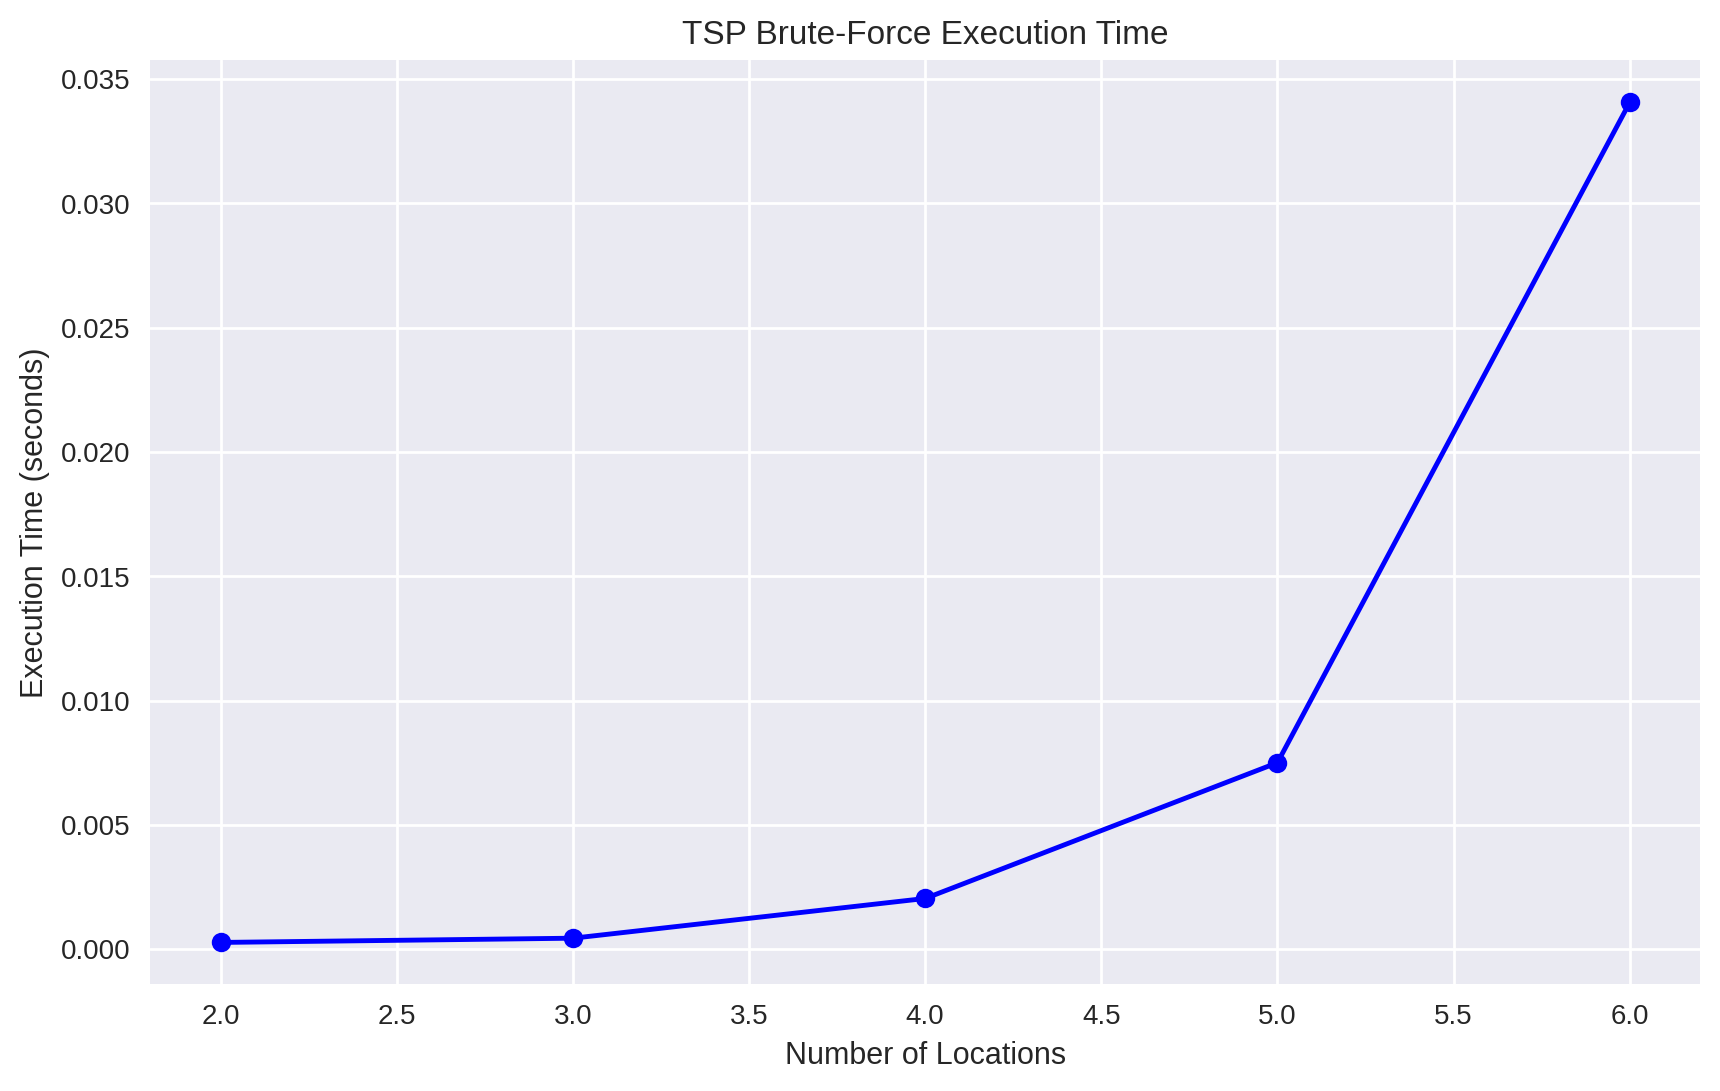

In [10]:
# Performance Analysis
def benchmark_tsp(location_count):
    """Benchmark TSP solution time for different numbers of locations."""
    times = []
    max_locations = min(location_count, 10)  # Keep n ≤ 10 for brute-force
    
    for n in range(2, max_locations + 1):
        subset = dict(list(location_coords.items())[:n])
        distance_matrix = calculate_distance_matrix(subset)
        
        start_time = time.time()
        _, _ = tsp_brute_force(distance_matrix)
        execution_time = time.time() - start_time
        
        times.append(execution_time)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_locations + 1), times, 'bo-')
    plt.title('TSP Brute-Force Execution Time')
    plt.xlabel('Number of Locations')
    plt.ylabel('Execution Time (seconds)')
    plt.grid(True)
    plt.show()

display(Markdown("### Performance Analysis"))
benchmark_tsp(len(locations))

## Performance Analysis
This section demonstrates how execution time grows with problem size:
1. Tests TSP solution for subsets of locations (2 to n)
2. Plots execution time vs. number of locations
3. Shows exponential time complexity characteristic of brute-force

The plot clearly shows why brute-force is impractical for large n - execution time grows factorially.

In [11]:
# Generalized Solution
def solve_tsp_for_any_locations(location_names):
    """Complete TSP solution pipeline for any list of locations."""
    # 1. Get coordinates
    coords = {}
    for loc in location_names:
        coord = get_coordinates(loc)
        if coord:
            coords[loc] = coord
        else:
            print(f"Warning: Could not find coordinates for {loc}")
    
    if len(coords) < 2:
        print("Error: Need at least 2 valid locations")
        return None
    
    # 2. Calculate distance matrix
    distance_matrix = calculate_distance_matrix(coords)
    
    # 3. Solve TSP (use heuristic for large n)
    if len(coords) <= 10:
        route, distance = tsp_brute_force(distance_matrix)
    else:
        # Placeholder for heuristic solution
        print("Too many locations for brute-force - implement heuristic")
        return None
    
    # 4. Visualize
    display(Markdown("### Optimal Route"))
    display(Markdown(f"**Route:** {' → '.join(route)}"))
    display(Markdown(f"**Distance:** {distance:.2f} km"))
    
    return plot_route(coords, route)

# Example usage with different locations
display(Markdown("### Generalized Solution Example"))
new_locations = ["Mombasa", "Kisumu", "Eldoret", "Thika"]
solve_tsp_for_any_locations(new_locations)

### Generalized Solution Example

### Optimal Route

**Route:** Mombasa → Kisumu → Eldoret → Thika → Mombasa

**Distance:** 1494.24 km